In [45]:
import os
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D

from pathlib import Path
import numpy as np
import tensorflow as tf

In [46]:
train_dir = os.path.join('Training_Datasets', 'train')
validation_dir = os.path.join('Training_Datasets', 'val')

train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 8, class_mode = 'categorical', target_size = (224, 224))

validation_generator = test_datagen.flow_from_directory( validation_dir, batch_size = 8, class_mode = 'categorical', target_size = (224, 224))


Found 4068 images belonging to 4 classes.
Found 1020 images belonging to 4 classes.


In [85]:
# Create an instance of ImageDataGenerator
datagen = ImageDataGenerator()

# Get the class indices from the generator
class_indices = datagen.flow_from_directory(train_dir, target_size = (224, 224), shuffle=False).class_indices

# Invert the dictionary to get the class labels
class_labels = dict((v,k) for k,v in class_indices.items())

# Print the class labels
print('Class labels:', class_labels)

Found 4068 images belonging to 4 classes.
Class labels: {0: 'Atlantic_Poison_Oak', 1: 'Eastern_Poison_Ivy', 2: 'Not', 3: 'Poison_Sumac'}


In [69]:
import efficientnet.keras as efn
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras import Model

# Define input layer with custom name using the functional API
inputs = Input(shape=(224, 224, 3), name='input_layer')
x = efn.EfficientNetB0(include_top=False, weights='imagenet', classes=4)(inputs)

# Define output layer
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(4, activation='softmax')(x)

# Combine input and output layers into a model using the functional API
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [70]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnet-b0 (Functional  (None, None, None, 1280)  4049564  
 )                                                               
                                                                 
 global_average_pooling2d_23  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_23 (Dropout)        (None, 1280)              0         
                                                                 
 dense_23 (Dense)            (None, 4)                 5124      
                                                                 
Total params: 4,054,688
Trainable params: 4,012,672
Non-tra

In [49]:
model.get_layer('efficientnet-b0')._name = 'efficientnetb0'

In [50]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049564   
                                                                 
 global_average_pooling2d_14  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_14 (Dropout)        (None, 1280)              0         
                                                                 
 dense_14 (Dense)            (None, 4)                 5124      
                                                                 
Total params: 4,054,688
Trainable params: 4,012,672
Non-trainable params: 42,016
_________________________________________________________________


In [71]:
num_epochs = 7
eff_history = model.fit(train_generator, validation_data = validation_generator, epochs = num_epochs)

Epoch 1/7
509/509 [==============================] - 185s 339ms/step - loss: 0.8232 - accuracy: 0.6576 - val_loss: 0.5625 - val_accuracy: 0.7863
Epoch 2/7
509/509 [==============================] - 171s 336ms/step - loss: 0.5244 - accuracy: 0.8009 - val_loss: 0.3842 - val_accuracy: 0.8490
Epoch 3/7
509/509 [==============================] - 173s 340ms/step - loss: 0.4202 - accuracy: 0.8427 - val_loss: 0.3573 - val_accuracy: 0.8598
Epoch 4/7
509/509 [==============================] - 174s 341ms/step - loss: 0.3614 - accuracy: 0.8687 - val_loss: 0.3224 - val_accuracy: 0.8843
Epoch 5/7
509/509 [==============================] - 177s 347ms/step - loss: 0.3091 - accuracy: 0.8847 - val_loss: 0.3885 - val_accuracy: 0.8745
Epoch 6/7
509/509 [==============================] - 181s 356ms/step - loss: 0.3150 - accuracy: 0.8788 - val_loss: 0.2809 - val_accuracy: 0.9078
Epoch 7/7
509/509 [==============================] - 180s 354ms/step - loss: 0.2620 - accuracy: 0.9034 - val_loss: 0.3024 - val_ac

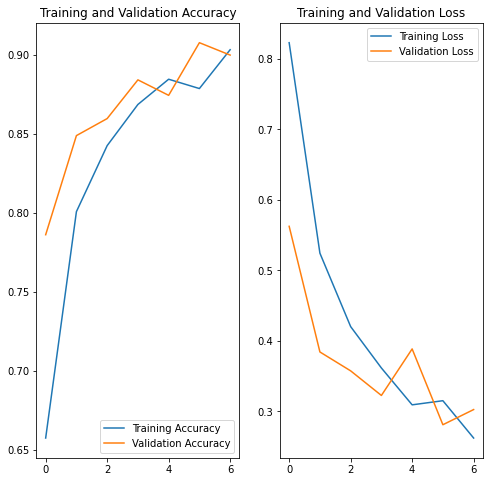

In [72]:
import matplotlib.pyplot as plt
acc = eff_history.history['accuracy'] 
val_acc = eff_history.history['val_accuracy']

loss = eff_history.history['loss'] 
val_loss = eff_history.history['val_loss']

epochs_range = range(7)

plt.figure(figsize=(8, 8)) 
plt.subplot(1, 2, 1) 
plt.plot(epochs_range, acc, label='Training Accuracy') 
plt.plot(epochs_range, val_acc, label='Validation Accuracy') 
plt.legend(loc='lower right') 
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2) 
plt.plot(epochs_range, loss, label='Training Loss') 
plt.plot(epochs_range, val_loss, label='Validation Loss') 
plt.legend(loc='upper right') 
plt.title('Training and Validation Loss') 
plt.show()

In [73]:
model.save("poisonous_plant_classifier_model")

INFO:tensorflow:Assets written to: poisonous_plant_classifier_model/assets


INFO:tensorflow:Assets written to: poisonous_plant_classifier_model/assets


In [84]:
class_names_train = list(train_generator.class_indices.keys())

print(class_names_train)

['Atlantic_Poison_Oak', 'Eastern_Poison_Ivy', 'Not', 'Poison_Sumac']
